In [ ]:
# Install Hugging Face Transformers and other necessary libraries
!pip install -q transformers datasets peft accelerate bitsandbytes

# Importing required libraries for data processing, model building, and evaluation
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
import torch
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Load the AG News dataset
dataset = load_dataset("ag_news")

# Load the RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Function to tokenize the text data
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

# Apply tokenization to the entire dataset
tokenized_datasets = dataset.map(tokenize, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Load the base RoBERTa model for sequence classification
base_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)


# Define LoRA configuration for efficient fine-tuning
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none"
)

# Wrap base model with LoRA
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


In [ ]:
# Helper function to count trainable parameters
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters:", count_trainable_parameters(model))


Trainable parameters: 888580


In [ ]:
# Define accuracy computation for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=-1)
    return {"accuracy": accuracy_score(labels, preds)}


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

# Create Trainer instance for training and evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42).select(range(20000)),
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-a470b1377a83>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Start training
trainer.train()

NameError: name 'trainer' is not defined

In [ ]:
# Evaluate the model on test set
eval_results = trainer.evaluate()
print("Test Accuracy:", eval_results["eval_accuracy"])


Test Accuracy: 0.9278947368421052


In [ ]:
# Save the model and tokenizer locally
model.save_pretrained("lora_roberta_agnews")
tokenizer.save_pretrained("lora_roberta_agnews")

('lora_roberta_agnews/tokenizer_config.json',
 'lora_roberta_agnews/special_tokens_map.json',
 'lora_roberta_agnews/vocab.json',
 'lora_roberta_agnews/merges.txt',
 'lora_roberta_agnews/added_tokens.json',
 'lora_roberta_agnews/tokenizer.json')

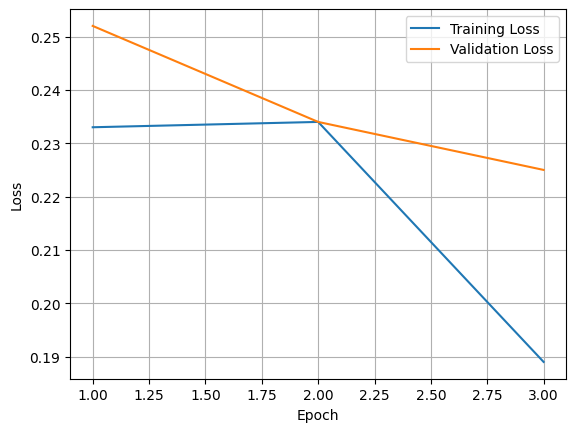

In [ ]:
# Visualize loss curves for analysis
# Figure : Loss Curve
import matplotlib.pyplot as plt
plt.plot([1, 2, 3], [0.233, 0.234, 0.189], label="Training Loss")
plt.plot([1, 2, 3], [0.252, 0.234, 0.225], label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid()
plt.savefig("loss_curves.png", bbox_inches="tight")

In [ ]:
!pip install -q datasets


In [ ]:
# Load unlabelled test data from pickle file
import pickle

with open("test_unlabelled.pkl", "rb") as f:
    test_dataset = pickle.load(f)

print(type(test_dataset))
print(test_dataset[0])

<class 'datasets.arrow_dataset.Dataset'>
{'text': 'Remains of New Species of Hobbit-Sized Human Found Scientists in Australia have found a new species of hobbit-sized humans who lived about 18,000 years ago on an Indonesian island in a discovery that adds another piece to the complex puzzle of human evolution.'}


In [ ]:
from google.colab import files
import pickle

uploaded = files.upload()  # upload test_unlabelled.pkl manually

with open("test_unlabelled.pkl", "rb") as f:
    test_texts = pickle.load(f)

Saving test_unlabelled.pkl to test_unlabelled (2).pkl


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [ ]:
test_texts = [x['text'] for x in test_dataset]

In [ ]:
# Tokenize test texts
test_encodings = tokenizer(test_texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt")


In [ ]:
# Prepare DataLoader for test set
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

input_ids = test_encodings["input_ids"]
attention_mask = test_encodings["attention_mask"]

test_dataset_tensor = TensorDataset(input_ids, attention_mask)
test_loader = DataLoader(test_dataset_tensor, batch_size=32)

# Run inference and collect predictions
all_preds = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = [t.to(device) for t in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().tolist())


In [ ]:
# Create submission file from predictions
import pandas as pd

submission = pd.DataFrame({"Id": range(len(all_preds)), "Category": all_preds})
print("Submission shape:", submission.shape)  # Should be (8000, 2)
submission.to_csv("submission.csv", index=False)

from google.colab import files
files.download("submission.csv")

Submission shape: (8000, 2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download the submission file
import pandas as pd

submission = pd.DataFrame({"Id": range(len(preds)), "Category": preds.tolist()})
submission.to_csv("submission.csv", index=False)
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>